In [24]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from matplotlib.colors import BoundaryNorm
from numpy.typing import NDArray
from prepare_sufosat_v3_layer import prepare_sufosat_v3_layer
from pyproj import Transformer
from rasterio.windows import from_bounds
from shapely import Point, box
from tqdm import tqdm

In [3]:
# Download Sufosat data
!mkdir -p ../data/sufosat
!wget https://zenodo.org/records/15004634/files/forest-clearcuts_mainland-france_sufosat_dates_v3.tif?download=1 -O ../data/sufosat/forest-clearcuts_mainland-france_sufosat_dates_v3.tif
!wget https://zenodo.org/records/15004634/files/forest-clearcuts_mainland-france_sufosat_prob_v3.tif?download=1 -O ../data/sufosat/forest-clearcuts_mainland-france_sufosat_prob_v3.tif

--2025-03-15 19:31:37--  https://zenodo.org/records/15004634/files/forest-clearcuts_mainland-france_sufosat_dates_v3.tif?download=1
Resolving zenodo.org (zenodo.org)... 2001:1458:d00:61::100:2f3, 2001:1458:d00:25::100:372, 2001:1458:d00:24::100:f6, ...
Connecting to zenodo.org (zenodo.org)|2001:1458:d00:61::100:2f3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 249853638 (238M) [image/tiff]
Saving to: ‘../data/sufosat/forest-clearcuts_mainland-france_sufosat_dates_v3.tif’

../data/sufosat/for 100%[===================>] 238,28M  78,4MB/s    in 3,0s    

2025-03-15 19:31:40 (78,4 MB/s) - ‘../data/sufosat/forest-clearcuts_mainland-france_sufosat_dates_v3.tif’ saved [249853638/249853638]

--2025-03-15 19:31:41--  https://zenodo.org/records/15004634/files/forest-clearcuts_mainland-france_sufosat_prob_v3.tif?download=1
Resolving zenodo.org (zenodo.org)... 2001:1458:d00:24::100:f6, 2001:1458:d00:25::100:372, 2001:1458:d00:61::100:2f3, ...
Connecting to zenodo.org (z

In [2]:
# Notebook variables
INPUT_RASTER_DATES = (
    "../data/sufosat/forest-clearcuts_mainland-france_sufosat_dates_v3.tif"
)
INPUT_RASTER_PROBAS = (
    "../data/sufosat/forest-clearcuts_mainland-france_sufosat_prob_v3.tif"
)
TEMP_OUTPUT_VECTOR_DATES = "../data/sufosat/sufosat_v3.fgb"
OUTPUT_LAYER = "../data/sufosat/sufosat_clear_cuts_v3.fgb"
MAX_METERS_BETWEEN_CLEAR_CUTS = 100
MAX_DAYS_BETWEEN_CLEAR_CUTS = 365
MAGIC_NUMBER = 0.42
MIN_CLEAR_CUT_AREA_HA = 0.5

## Quickly exploring SUFOSAT v3

<span style="color: red;">v3 observations<span>

- We need a new function to parse the clear-cut dates. The pixel values are now `YYDDD`, where `YY` is the estimated year of logging (between 18 and 25) and `DDD` is the day of the year (between 1 and 366).
- The TIFF file now uses the Lambert-93 CRS instead of the WGS 84 CRS.
- The detected clear-cuts are less conservative compared to v2. For instance, with the example plot, in v2, the road separating the fields was correctly labeled, whereas here it is labeled as part of the clear-cut. This will certainly lead to false positives and exaggerated estimations of clear-cut areas.


### Plot an example


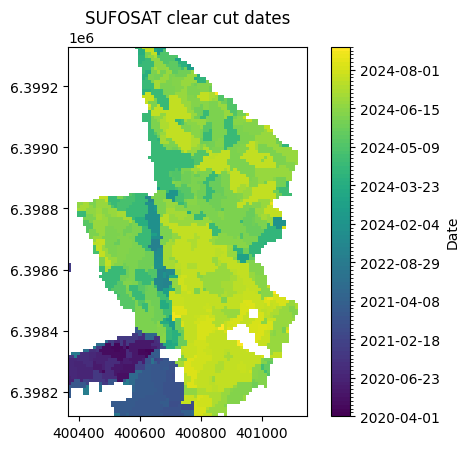

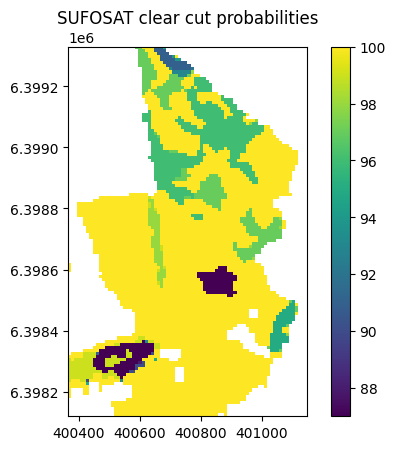

In [3]:
def load_raster_subset(
    raster_path: str,
    minx: float,
    maxx: float,
    miny: float,
    maxy: float,
) -> tuple[NDArray[np.floating], tuple[float]]:
    # Load a subset of a raster file based on given bounds.
    with rasterio.open(raster_path) as src:
        window = from_bounds(
            left=minx, bottom=miny, right=maxx, top=maxy, transform=src.transform
        )
        data = src.read(1, window=window)

        # Get updated transform for the subset
        transform = src.window_transform(window)

    # Prepare data for plotting
    data = data.astype(float)
    data[data == 0] = np.nan

    # Compute extent for imshow
    left, top = transform * (0, 0)  # Upper-left corner in world coordinates
    right, bottom = transform * (data.shape[1], data.shape[0])  # Lower-right corner
    extent = (left, right, bottom, top)

    return data, extent


def parse_sufosat_date(sufosat_date: float) -> pd.Timestamp:
    sufosat_date = int(sufosat_date)
    return pd.Timestamp(
        year=2000 + sufosat_date // 1000, month=1, day=1
    ) + pd.Timedelta(days=(sufosat_date % 1000) - 1)


def plot_raster_dates(
    data: NDArray[np.floating],
    extent: tuple[float],
    clear_cut: gpd.GeoDataFrame | None = None,
) -> None:
    # Set up color mapping
    categories_thresholds = np.unique(data[~np.isnan(data)])
    if len(categories_thresholds) < 2:
        categories_thresholds = np.array(
            [categories_thresholds[0] - 1, categories_thresholds[0] + 1]
        )
    # Use the recommended way to get colormap
    cmap = plt.colormaps["viridis"].resampled(len(categories_thresholds))
    norm = BoundaryNorm(
        boundaries=categories_thresholds, ncolors=len(categories_thresholds)
    )

    # Create plot
    fig, ax = plt.subplots()
    img = ax.imshow(data, cmap=cmap, norm=norm, extent=extent)

    # Configure colorbar with dates
    cbar = plt.colorbar(img)
    tick_values = cbar.get_ticks()
    tick_labels = [
        parse_sufosat_date(tick).strftime("%Y-%m-%d") for tick in tick_values
    ]

    cbar.set_ticks(tick_values)
    cbar.set_ticklabels(tick_labels)
    cbar.set_label("Date")

    # Plot the clear cut polygon
    if clear_cut is not None:
        clear_cut.to_crs(epsg=4326).plot(
            ax=ax, facecolor="none", edgecolor="red", linewidth=1
        )

    plt.title("SUFOSAT clear cut dates")
    plt.show()


def plot_raster_probabilities(data: NDArray[np.floating], extent: tuple[float]) -> None:
    plt.imshow(data, extent=extent)
    plt.colorbar()
    plt.title("SUFOSAT clear cut probabilities")
    plt.show()


def plot_example(gdf_group: gpd.GeoDataFrame, long: float, lat: float) -> None:
    # Convert longitude and latitude from WGS84 (EPSG:4326) to Lambert 93 (EPSG:2154)
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:2154", always_xy=True)
    point = Point(transformer.transform(long, lat))
    clear_cut = gdf_group[gdf_group.contains(point)]
    print("ID =", clear_cut.index[0])

    # See for yourself with Sentinel 2 images
    print(f"https://browser.dataspace.copernicus.eu/?zoom=17&lat={lat}&lng={long}")
    print(f"https://www.google.com/maps?q={lat},{long}")

    # Clear cut area
    print(f"{clear_cut.area.iloc[0] / 10000:.2f} hectares clear cut")

    # Plot the raster data (maybe we could overlay both in one plot)
    minx, miny, maxx, maxy = (
        clear_cut.to_crs(epsg=4326).geometry.bounds.iloc[0].tolist()
    )
    data, extent = load_raster_subset(
        raster_path=INPUT_RASTER_DATES, minx=minx, miny=miny, maxx=maxx, maxy=maxy
    )
    plot_raster_dates(data, extent, clear_cut)


# Define the transformation from WGS 84 (EPSG:4326) to Lambert-93 (EPSG:2154)
transformer = Transformer.from_crs("EPSG:4326", "EPSG:2154", always_xy=True)

# Bounding box
minx, miny = transformer.transform(-0.7781456631782495, 44.61761959544384)
maxx, maxy = transformer.transform(-0.7690339007836599, 44.62885826228384)

plot_raster_dates(
    *load_raster_subset(
        raster_path=INPUT_RASTER_DATES,
        minx=minx,
        maxx=maxx,
        miny=miny,
        maxy=maxy,
    )
)
plot_raster_probabilities(
    *load_raster_subset(
        raster_path=INPUT_RASTER_PROBAS,
        minx=minx,
        maxx=maxx,
        miny=miny,
        maxy=maxy,
    )
)

### Explore the clear cut probabilties file


In [4]:
def explore_probabilities() -> None:
    """
    This function describes the SUFOSAT clear cuts probabilities
    """
    probas = []
    with rasterio.open(INPUT_RASTER_PROBAS) as src:
        # Read the data as a generator (window-by-window) to avoid out Of memory issues
        # since the total grid contains billions of points
        for _, window in tqdm(
            src.block_windows(),
            total=src.width
            * src.height
            // (src.block_shapes[0][0] * src.block_shapes[0][1]),
        ):
            # Read the block data for the first and only band
            data = src.read(1, window=window)

            # Ignore the block if it contains no data
            if np.all(data == src.nodata):
                continue

            data_probas = data.flatten()
            data_probas = data_probas[data_probas != 0]
            probas.append(data_probas)

    # Show probabilities statistics
    display(
        pd.Series(np.concatenate(probas)).quantile(
            [0, 0.001, 0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99, 1]
        )
    )


explore_probabilities()

  0%|          | 0/14410 [00:00<?, ?it/s]

14508it [00:49, 294.33it/s]                           


0.000     56.0
0.001     85.0
0.010     87.0
0.050     91.0
0.250     96.0
0.500    100.0
0.750    100.0
0.950    100.0
0.990    100.0
1.000    100.0
dtype: float64

<span style="color: red;">v3 observations<span>

The minimum probability is 56%, but it's an outlier.
Most of the probabilities are still very high, greater than 80%.
I guess we can keep ignoring this probability file.


## Cluster clear cuts by space and time


In [4]:
prepare_sufosat_v3_layer(
    input_raster_dates=INPUT_RASTER_DATES,
    temp_output_vector_dates=TEMP_OUTPUT_VECTOR_DATES,
    output_layer=OUTPUT_LAYER,
    max_meters_between_clear_cuts=MAX_METERS_BETWEEN_CLEAR_CUTS,
    max_days_between_clear_cuts=MAX_DAYS_BETWEEN_CLEAR_CUTS,
    min_clear_cut_area_ha=MIN_CLEAR_CUT_AREA_HA,
    concave_hull_ratio=MAGIC_NUMBER,
    concave_hull_threshold=MAGIC_NUMBER,
)

[19:09:36][INFO] Starting to process ../data/sufosat/forest-clearcuts_mainland-france_sufosat_dates_v3.tif
[19:09:36][INFO] Polygonizing raster: ../data/sufosat/forest-clearcuts_mainland-france_sufosat_dates_v3.tif -> ../data/sufosat/sufosat_v3.fgb


[19:15:53][INFO] Polygonization complete: ../data/sufosat/sufosat_v3.fgb
[19:17:18][INFO] Clustering clear-cuts by spatial and temporal proximity
[19:17:18][INFO] Pairing clear-cuts within 100 meters and 365 days of each other
[19:21:29][INFO] Found 63350487 potential clear-cut pairs (before shape complexity filtering)
[19:21:29][INFO] Grouping connected clear-cuts into clusters
Merging connected clear-cuts: 100%|██████████| 63350487/63350487 [02:15<00:00, 468693.94it/s]
[19:23:52][INFO] Created 239744 clear-cut clusters
[19:23:52][INFO] Assigning cluster IDs to clear-cuts
Assigning cluster IDs: 100%|██████████| 239744/239744 [01:05<00:00, 3685.75it/s]
[19:24:57][INFO] Clustering complete: 239744 total clusters
[19:24:58][INFO] Merging clear-cuts within each cluster
[19:24:58][INFO] Performing spatial union of geometries within each cluster
[19:31:07][INFO] Filling tiny gaps in the dissolved geometries
[19:31:54][INFO] Successfully created 239744 merged clear-cut clusters
[19:31:56][IN

In [ ]:
# Loading the result
gdf = gpd.read_file(
    "/home/ycrouin/Desktop/13_brigade_coupes_rases/analytics/data/sufosat/sufosat_clear_cuts_v3.fgb"
)
gdf

,date_min,date_max,days_delta,clear_cut_group_size,area_ha,geometry
0,2018-12-07,2019-02-17,72,13,0.520004,"MULTIPOLYGON (((1219789.689 6054526.697, 12197..."
1,2019-12-01,2019-12-31,30,6,0.520004,"MULTIPOLYGON (((1221859.689 6054536.697, 12218..."
2,2023-06-07,2023-12-05,181,13,0.920005,"MULTIPOLYGON (((1221159.688 6055586.697, 12211..."
3,2021-01-13,2023-03-15,791,137,11.550035,"MULTIPOLYGON (((1219859.689 6055366.697, 12198..."
4,2019-02-04,2019-09-08,216,38,2.760023,"MULTIPOLYGON (((1219649.689 6059146.697, 12196..."
...,...,...,...,...,...,...
207333,2020-03-13,2021-05-30,443,19,1.220009,"MULTIPOLYGON (((315009.689 6262906.697, 315009..."
207334,2019-03-25,2021-03-31,737,62,4.690016,"MULTIPOLYGON (((315369.688 6261636.697, 315369..."
207335,2024-05-03,2024-07-26,84,13,1.100006,"MULTIPOLYGON (((315689.689 6262016.697, 315689..."
207336,2020-05-12,2021-07-12,426,13,0.820007,"MULTIPOLYGON (((314999.689 6264926.697, 314999..."


<Axes: >

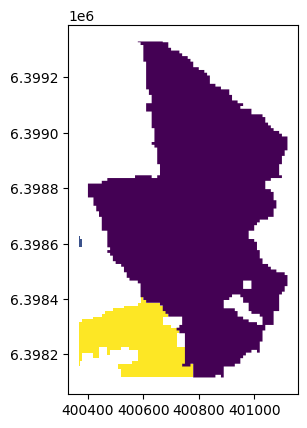

In [36]:
# Plotting our example
gdf.clip(box(minx, miny, maxx, maxy)).reset_index().plot(column="index")

In [39]:
# There are some clear-cut areas greater than 1000 ha.
# The most recent one actually matches the wildfires near the Dune of Pilat, that's a false positive.
# The others could be large agglomerates.
gdf.sort_values("area_ha")

,date_min,date_max,days_delta,clear_cut_group_size,area_ha,geometry
202574,2021-07-20,2021-10-12,84,7,0.500003,"MULTIPOLYGON (((598329.689 6238316.697, 598329..."
181423,2023-02-03,2023-02-08,5,3,0.500003,"MULTIPOLYGON (((524069.689 6403936.697, 524069..."
57915,2020-08-01,2020-08-13,12,4,0.500003,"MULTIPOLYGON (((678709.689 7062036.697, 678709..."
164195,2020-06-30,2020-07-24,24,5,0.500003,"MULTIPOLYGON (((641099.689 6482926.697, 641109..."
120388,2019-03-20,2019-06-08,80,5,0.500003,"MULTIPOLYGON (((669149.689 6827376.697, 669149..."
...,...,...,...,...,...,...
2222,2019-12-12,2023-02-06,1152,9805,1052.351660,"MULTIPOLYGON (((979719.688 6249746.697, 979719..."
111618,2018-06-15,2024-10-24,2323,10215,1129.801242,"MULTIPOLYGON (((473999.689 6728826.697, 473999..."
186203,2018-06-15,2025-01-09,2400,11486,2510.162500,"MULTIPOLYGON (((384519.688 6431406.697, 384519..."
148446,2019-02-05,2024-12-07,2132,20624,2993.155838,"MULTIPOLYGON (((484989.689 6457136.697, 484989..."


## Upload the result to S3


In [40]:
# Upload to s3
!aws s3 cp ../data/sufosat/sufosat_clear_cuts_v3.fgb s3://brigade-coupe-rase-s3/analytics/data/sufosat/sufosat_clear_cuts_v3.fgb --profile d4g-s13-brigade-coupes-rases

upload: ../data/sufosat/sufosat_clear_cuts_v3.fgb to s3://brigade-coupe-rase-s3/analytics/data/sufosat/sufosat_clear_cuts_v3.fgb


In [42]:
!aws s3 ls s3://brigade-coupe-rase-s3/analytics --recursive --profile d4g-s13-brigade-coupes-rases

2025-02-25 09:31:33   96946219 analytics/data
2025-03-02 19:58:22  114393184 analytics/data/abusive_clear_cuts/abusive_clear_cuts_2024.fgb
2025-03-02 18:53:00  517567704 analytics/data/cadastre/cadastre_france_cities.fgb
2025-03-02 18:53:03   28085888 analytics/data/cadastre/cadastre_france_departments.fgb
2025-02-21 18:43:11  558882864 analytics/data/ign/bdalti25/slope_gte_30.fgb
2025-02-21 18:42:55   32993275 analytics/data/ign/bdalti25/slope_gte_30.tif
2025-02-25 09:58:17   96946219 analytics/data/sufosat/mosaics_tropisco_warnings_france_date.tif
2025-02-25 10:08:57   76601154 analytics/data/sufosat/mosaics_tropisco_warnings_france_prob.tif
2025-02-21 13:26:51  120737768 analytics/data/sufosat/sufosat_clear_cuts_2024.fgb
2025-03-16 20:51:40 1925723784 analytics/data/sufosat/sufosat_clear_cuts_v3.fgb
